# Stereo Estimation

If you are working in Colab,
*   Open Files from left
*   Drag and drop `Week2_Stereo.zip` there (or click upload icon on top left). Upload can take a few minutes.
*   Unzip the file by running the following cell.



In [2]:
# Retrieving the file ID for a file in `"/content/drive/My Drive/"`:
!apt-get install -qq xattr
filename = "/content/drive/MyDrive/hw3/vo/vo.ipynb"
id = !xattr -p 'user.drive.id' {filename}
print(id)

Selecting previously unselected package python3-cffi-backend.
(Reading database ... 155632 files and directories currently installed.)
Preparing to unpack .../0-python3-cffi-backend_1.11.5-1_amd64.deb ...
Unpacking python3-cffi-backend (1.11.5-1) ...
Selecting previously unselected package python3-ply.
Preparing to unpack .../1-python3-ply_3.11-1_all.deb ...
Unpacking python3-ply (3.11-1) ...
Selecting previously unselected package python3-pycparser.
Preparing to unpack .../2-python3-pycparser_2.18-2_all.deb ...
Unpacking python3-pycparser (2.18-2) ...
Selecting previously unselected package python3-cffi.
Preparing to unpack .../3-python3-cffi_1.11.5-1_all.deb ...
Unpacking python3-cffi (1.11.5-1) ...
Selecting previously unselected package python3-pkg-resources.
Preparing to unpack .../4-python3-pkg-resources_39.0.1-2_all.deb ...
Unpacking python3-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python3-xattr.
Preparing to unpack .../5-python3-xattr_0.9.2-0ubuntu1_

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/hw3/stereo

/content/drive/MyDrive/hw3/stereo


*   If you get disconnected from the runtime, you might need to upload this file again. Also, note that this is valid for other local files too eg. repos that have been cloned, files generated during execution etc. In short, if you see that your files are gone after a while, just run the cell that generates, clones, etc. the missing files again.

## Part B: 3D

### Visualizing 3D data

Throughout the course, you will create mesh files (the ones with `ply` extension) for storing 3D data. You can visualize 3D data using a program such as MeshLab or Open3D. We recommend you to visualize `ply` files in your local machine as it is challenging in a notebook.   

**MeshLab**:
*   Install MeshLab: https://www.meshlab.net/#download
*   Visualize ply files: dragging `ply` file into an open MeshLab window should work.

**Open3D**:   
*   Install Open3D: http://www.open3d.org/docs/release/getting_started.html
*   Visualize ply file: http://www.open3d.org/docs/latest/tutorial/Basic/file_io.html#Mesh



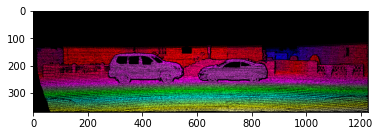

In [ ]:
import matplotlib.pyplot as plt
from util import *

# load the data
leftI = load_image('data/000005_10_left_color.png')
rightI = load_image('data/000005_10_right_color.png')
dispI_gt = load_disp('data/000005_10_gt.png') #ground truth
max_disp = np.max(dispI_gt)

plt.imshow(disp_to_color(dispI_gt, max_disp))

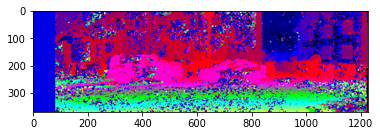

In [ ]:
NUM_DISP = 80
WINDOW_SIZE = 7

# print(leftI.shape) # (370, 1226, 3)
# print(rightI.shape) # (370, 1226, 3)

# use OPenCV's StereoSGBM method to compute disparity estimation dispI_est
# between the left image and the right image
pred = cv2.StereoSGBM_create(numDisparities=NUM_DISP, blockSize=WINDOW_SIZE)
dispI_est = pred.compute(leftI, rightI) 

# do not forget to divide the result by 16
dispI_est =  dispI_est / 16 # estimated disparity
max_disp = np.max(dispI_est)

plt.imshow(disp_to_color(dispI_est, max_disp))

In [ ]:
### KITTI parameters ###
f = 718.86
cx = 607.19
cy = 185.22
B = 0.537

# triangulate 3D Points
all_colors = cv2.cvtColor(leftI, cv2.COLOR_BGR2RGB)
# print(all_colors.shape) # (370, 1226, 3)
height, width = leftI.shape[:2]
# print(height) # 370
# print(width) # 1226

def triangulate(dispI, fn):
    # compute the 3D points for the given disparity image and their corresponding colors
    # by implementing triangulation (back-projection)

    # Find z -> z = B * f / d
    z = (f * B) / dispI + 1e-10 # 370 x 1226

    # Find 3D x and y from 2D
    x_s = np.zeros(dispI.shape)
    y_s = np.zeros(dispI.shape)

    for h in range(height): 
      x_s[h] = h
      for w in range(width):
          y_s[h][w] = w

    x = project(x_s, cx, z, f) 
    y = project(y_s, cy, z, f)  

    # some divisions caused infinity, find them
    remv_coord = np.isinf(z)

    # remove the inf values
    colors = get_colors(remv_coord)
    points = get_points(x, y, z, remv_coord)

    # create .ply
    write2ply(points, colors, fn)

def get_colors(remv_coord):
    colors = np.array(all_colors)
    return colors[~remv_coord].reshape(1, -1)


def get_points(x, y, z, remv_coord):
    z = z[~remv_coord].reshape(1, -1)
    x = x[~remv_coord].reshape(1, -1)
    y = y[~remv_coord].reshape(1, -1)
    points = np.array((x,y,z))
    return points.transpose(2,1,0)

def project(x, cx, z, f):
  return np.multiply((x-cx),z)/f
    
triangulate(dispI_gt, 'out/pts_gt.ply')
triangulate(dispI_est, 'out/pts_est.ply')

print('done!')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


done!


Visualize the 3D point clouds using MeshLab or Open3D. Note that you might have to rotate the point cloud a little bit until you can make sense of it, especially with the estimated disparity map where there are outliers.

**Bonus**: Implement the outlier ratio metric of the KITTI to evaluate the estimation quantitatively.